### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from filtering.enkf import EnKF
from model.linear2D import Linear2D
from model.parameter import Parameter
from utils import default_generator
from utils.plotter import Plotter
from utils.compare import Comparator

Plotter.fig_folder = "figs_param_estim_linear"

### Linear oscillator

In [2]:
generator = default_generator

init_state = np.array([np.pi / 2, 6.5])
init_state_cov = 0.5 * np.eye(len(init_state))
n_states = len(init_state)
n_obs = 2

p1 = -2
p2 = -0.5
params = [
    Parameter(
        p1,
        uncertainty=0.7,
        name="$\\theta_1$",
        estimate=True,
        # stochastic_propagation=True,
        # stochastic_integration=True,
    ),
    Parameter(
        p2,
        uncertainty=0.7,
        name="$\\theta_2$",
        estimate=True,
        # stochastic_propagation=True,
        # stochastic_integration=True,
    ),
]

H = lambda _: np.eye(n_obs)
system_cov = lambda _: 0.1 * np.eye(n_states)
obs_cov = lambda _: 0.3 * np.eye(n_obs)

time_step = 0.01
init_time = 0
end_time = 20

### Generate true state

In [3]:
model = Linear2D(init_state, time_step, params, H, system_cov, obs_cov, generator)
times, states = model.integrate(init_time, end_time)

### Generate observations (with noise)

In [4]:
assimilation_step = 1
assimilation_times = np.linspace(1, end_time, int(end_time / assimilation_step))
observed = np.zeros((n_obs, len(assimilation_times)))
observed_true = np.zeros((n_obs, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / time_step)
    observed[:, i] = model.observe(states[:, k], add_noise=True)
    observed_true[:, i] = model.observe(states[:, k])

### EnKF twin experiment

100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


Localize: False


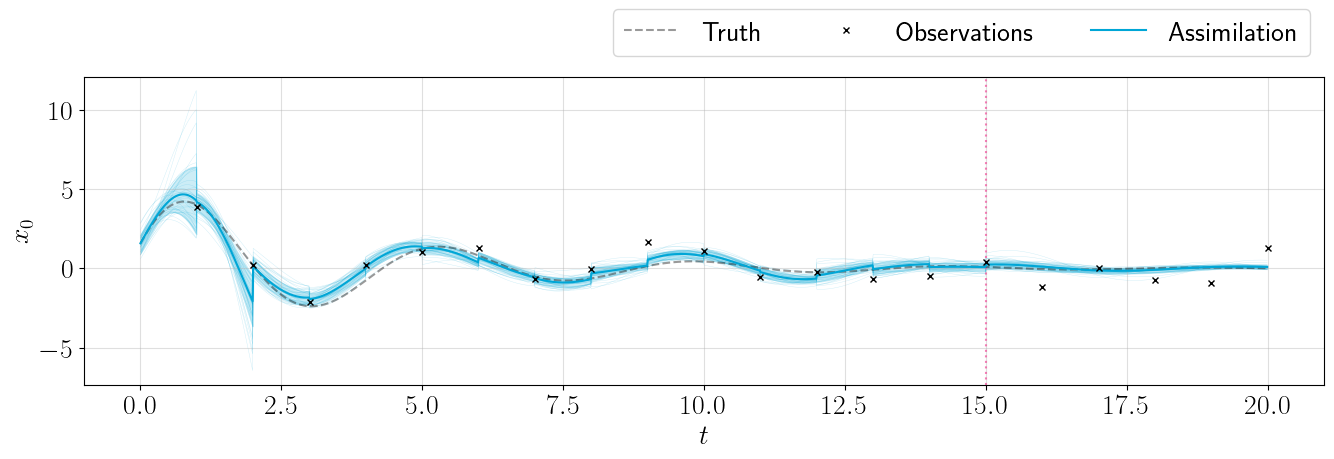

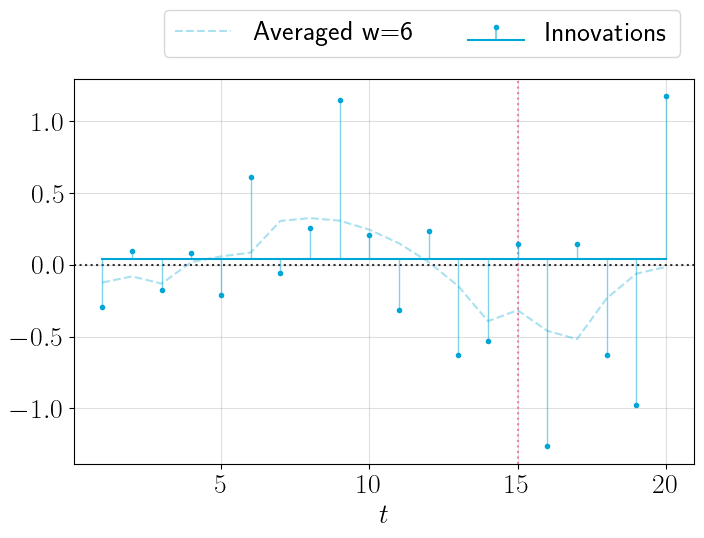

In [5]:
ensemble_size = 40
assimilation_data = observed

# Perturb parameters
model.reset_model(init_state)
perturbed_parameters = np.array([p1 - 1, p2 + 1])
for i, param in enumerate(model.uncertain_parameters):
    param.init_value = perturbed_parameters[i]
model.uncertain_parameters = perturbed_parameters

init_state_cov = 0.5 * np.eye(len(init_state))
f = EnKF(model, init_state, init_state_cov, ensemble_size)

results = f.filter(
    assimilation_times,
    observed,
    cut_off_time=15,
)
results.figsize = "horizontal"
results.true_times = times
results.true_states = states

# Run without assimilation
# model.reset_model(init_state)
# perturbed_parameters = np.array([p1 - 1, p2 + 1])
# for i, param in enumerate(model.uncertain_parameters):
#     param.estimate = False
#     param.init_value = perturbed_parameters[i]
# model.uncertain_parameters = perturbed_parameters
# f = EnKF(model, init_state, init_state_cov, ensemble_size)
# results_no_assim = f.filter(
#     assimilation_times,
#     observed,
#     cut_off_time=15,
# )

# c = Comparator([results, results_no_assim], ["EnKF", "No Assimilation"])
# i = 0
# c.compare_filtering(
#     state_idx=i,
#     plot_ensemble=False,
#     plot_bands=True,
#     figsize="horizontal",
#     path=f"compare_x{i}",
# )
# c.compare_innovations(
#     state_idx=i, figsize="horizontal", window=3, path=f"compare_inn_x{i}"
# )
# plt.show()


window = int(end_time / 3)
for i in range(1):
    results.plot_filtering(i, True, True, path=f"filter_x{i}")
    results.plot_innovations(i, window=window, path=f"innovations_x{i}")

<Axes: xlabel='$t$'>

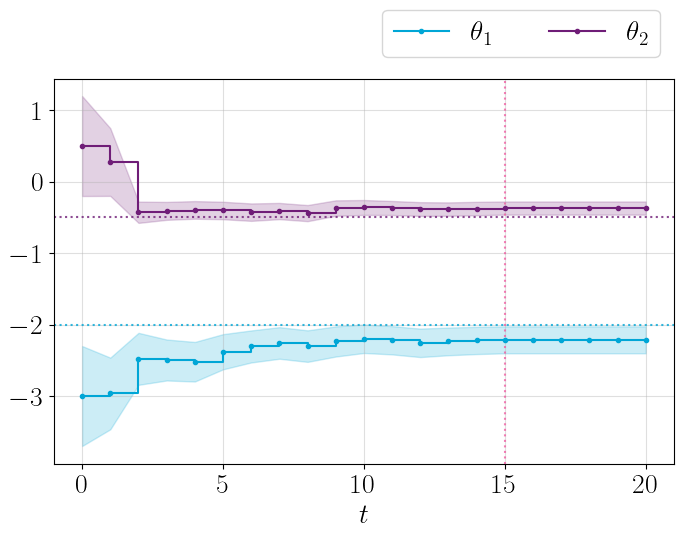

In [6]:
refs = [p1, p2]
results.plot_params([0, 1], refs, path="params")